In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker22
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from palettable.colorbrewer.qualitative import Pastel1_4
from xarrayMannKendall import *

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '../results/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:40759 Dashboard: /proxy/32797/status,Cluster Workers: 6 Cores: 24 Memory: 96.00 GiB


In [7]:
def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    else:
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

# Loading datasets

In [13]:
# JRA55do-v14
uas = {}
vas = {}
uas['ERAI'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc').sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERAI'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc').sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))

# CMIP6 multimodel mean
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc').sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc').sel(time = slice('1979-01-01', '2015-01-01'))

# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))
model_names = list(uas.keys())

In [9]:
shelf_regions = xr.open_dataset('~/g_e14/misc/Antarctic_shelf_basins.nc')
shelf_regions = change_lon_space(shelf_regions, 't')
basins = shelf_regions['basins'].where(shelf_regions['basins'] != 100, np.nan)
locs = list(shelf_regions['basin_lookup']['region'][:-1].values)
locs.remove('East Antarctica 04')

# Trends per basin (boxplot)

In [14]:
uas_trends = {}
for n in model_names:
    u = uas[n]['uas']
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    uas_trends[n] = MK_class.compute()

In [15]:
uas_trends_finer = {}
for n in model_names:
    uas_trends[n] = uas_trends[n].rename({'x':'lon', 'y':'lat'})
    uas_trends_finer[n] = uas_trends[n].interp(lon = basins['lon'], lat = basins['lat'])

uas_trends_basins = np.empty([len(model_names), len(locs)])
i = 0
for n in model_names:
    for j in range(len(locs)):
        uas_trends_basins[i, j-2] = uas_trends_finer[n]['trend'].where(basins == j+2, np.nan).mean(['lon', 'lat'])
    i += 1

In [16]:
vas_trends = {}
for n in model_names:
    v = vas[n]['vas']
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    vas_trends[n] = MK_class.compute()

In [17]:
vas_trends_finer = {}
for n in model_names:
    vas_trends[n] = vas_trends[n].rename({'x':'lon', 'y':'lat'})
    vas_trends_finer[n] = vas_trends[n].interp(lon = basins['lon'], lat = basins['lat'])

vas_trends_basins = np.empty([len(model_names), len(locs)])
i = 0
for n in model_names:
    for j in range(len(locs)):
        vas_trends_basins[i, j-2] = vas_trends_finer[n]['trend'].where(basins == j+2, np.nan).mean(['lon', 'lat'])
    i += 1

In [18]:
# Color codes for regions of positive or negative winds (helps to see if there is weakening or intensification)
coloring_uas_cmip = len(locs)*['lightsteelblue']
coloring_uas_erai = len(locs)*['lightsteelblue']
for n in range(len(locs)):
    uas_mean = uas['CMIP6']['uas'].mean('time').interp(lon = basins['lon'], lat = basins['lat']).where(basins == n+2, np.nan).mean(['lon', 'lat'])
    if uas_mean > 0:
        coloring_uas_cmip[n] = 'lightcoral'
    uas_mean = uas['ERAI']['uas'].mean('time').interp(lon = basins['lon'], lat = basins['lat']).where(basins == n+2, np.nan).mean(['lon', 'lat'])
    if uas_mean > 0:
        coloring_uas_erai[n] = 'lightcoral'

coloring_vas_cmip = len(locs)*['lightsteelblue']
coloring_vas_erai = len(locs)*['lightsteelblue']
for n in range(len(locs)):
    vas_mean = vas['CMIP6']['vas'].mean('time').interp(lon = basins['lon'], lat = basins['lat']).where(basins == n+2, np.nan).mean(['lon', 'lat'])
    if vas_mean > 0:
        coloring_vas_cmip[n] = 'lightcoral'
    vas_mean = vas['ERAI']['vas'].mean('time').interp(lon = basins['lon'], lat = basins['lat']).where(basins == n+2, np.nan).mean(['lon', 'lat'])
    if vas_mean > 0:
        coloring_vas_erai[n] = 'lightcoral'

In [19]:
legend_elements = [Line2D([0], [0], color = 'none', marker = 'd', markersize = 10, markeredgecolor = 'k', markerfacecolor = 'none', label = 'ERA-Interim mean'),
                   Line2D([0], [0], color = 'none', marker = 'o', markersize = 10, markeredgecolor = 'k', markerfacecolor = 'none', label = 'CMIP6 multimodel mean'),
                   mpatches.Patch(color = 'lightsteelblue', label = 'Negative mean wind'),
                   mpatches.Patch(color = 'lightcoral', label = 'Positive mean wind'),]

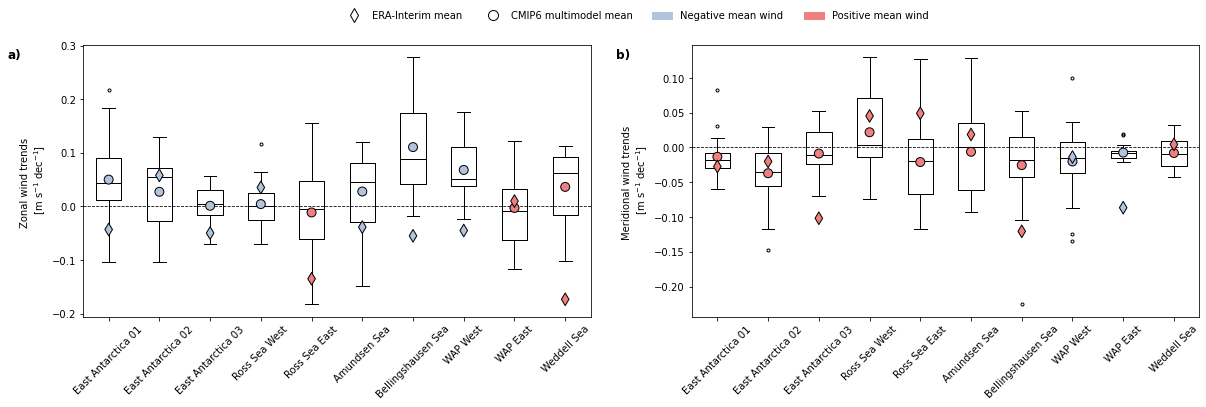

In [20]:
fig = plt.figure(figsize = (20,5))
gr = gs.GridSpec(1, 2, figure = fig); 
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1])]
axs[0].text(-0.15, .95, 'a)', transform=axs[0].transAxes, size = 12, weight='bold')
axs[1].text(-0.15, .95, 'b)', transform=axs[1].transAxes, size = 12, weight='bold')
axs[0].set_ylabel('Zonal wind trends \n [m s$^{-1}$ dec$^{-1}$]')
axs[1].set_ylabel('Meridional wind trends \n [m s$^{-1}$ dec$^{-1}$]')
axs[0].axhline(y = 0, linestyle = '--', color = 'k', linewidth = 0.8, zorder = 0)
axs[1].axhline(y = 0, linestyle = '--', color = 'k', linewidth = 0.8, zorder = 0)

axs[0].boxplot(uas_trends_basins[2:,:]*120, sym = '.', medianprops=dict(color = 'k'), labels = locs, zorder = 1);
axs[0].scatter(np.arange(1,11,1), uas_trends_basins[0,:]*120, s = 80, color = coloring_uas_erai, edgecolor = 'k', 
               marker = 'd', zorder = 3)
axs[0].scatter(np.arange(1,11,1), uas_trends_basins[1,:]*120, s = 80, color = coloring_uas_cmip, edgecolor = 'k',
               marker = 'o', zorder = 2)
axs[0].set_xticklabels(labels = locs, rotation = 45);

axs[1].boxplot(vas_trends_basins[2:,:]*120, sym = '.', medianprops=dict(color = 'k'), labels = locs, zorder = 1);
axs[1].scatter(np.arange(1,11,1), vas_trends_basins[0,:]*120, s = 80, color = coloring_vas_erai, edgecolor = 'k', 
               marker = 'd', zorder = 3)
axs[1].scatter(np.arange(1,11,1), vas_trends_basins[1,:]*120, s = 80, color = coloring_vas_erai, edgecolor = 'k', 
               marker = 'o', zorder = 2)
axs[1].set_xticklabels(labels = locs, rotation = 45);

fig.legend(handles = legend_elements, ncol = 4, loc = 'upper left', bbox_to_anchor = (.3, 1), frameon = False);
plt.savefig('../results/fig3.png', facecolor = 'white', bbox_inches = 'tight')

# Biases

In [30]:
uas_biases = np.empty([len(model_names)-1, len(locs)])
vas_biases = np.empty([len(model_names)-1, len(locs)])
for n in range(len(model_names[1:])):
    ua = uas[model_names[n+1]]['uas'].mean('time') - uas['ERAI']['uas'].mean('time')
    va = vas[model_names[n+1]]['vas'].mean('time') - vas['ERAI']['vas'].mean('time')
    for l in range(len(locs)):
        uas_biases[n, l] = ua.interp(lon = basins['lon'], lat = basins['lat']).where(basins == l+2, np.nan).mean(['lon', 'lat'])
        vas_biases[n, l] = va.interp(lon = basins['lon'], lat = basins['lat']).where(basins == l+2, np.nan).mean(['lon', 'lat'])

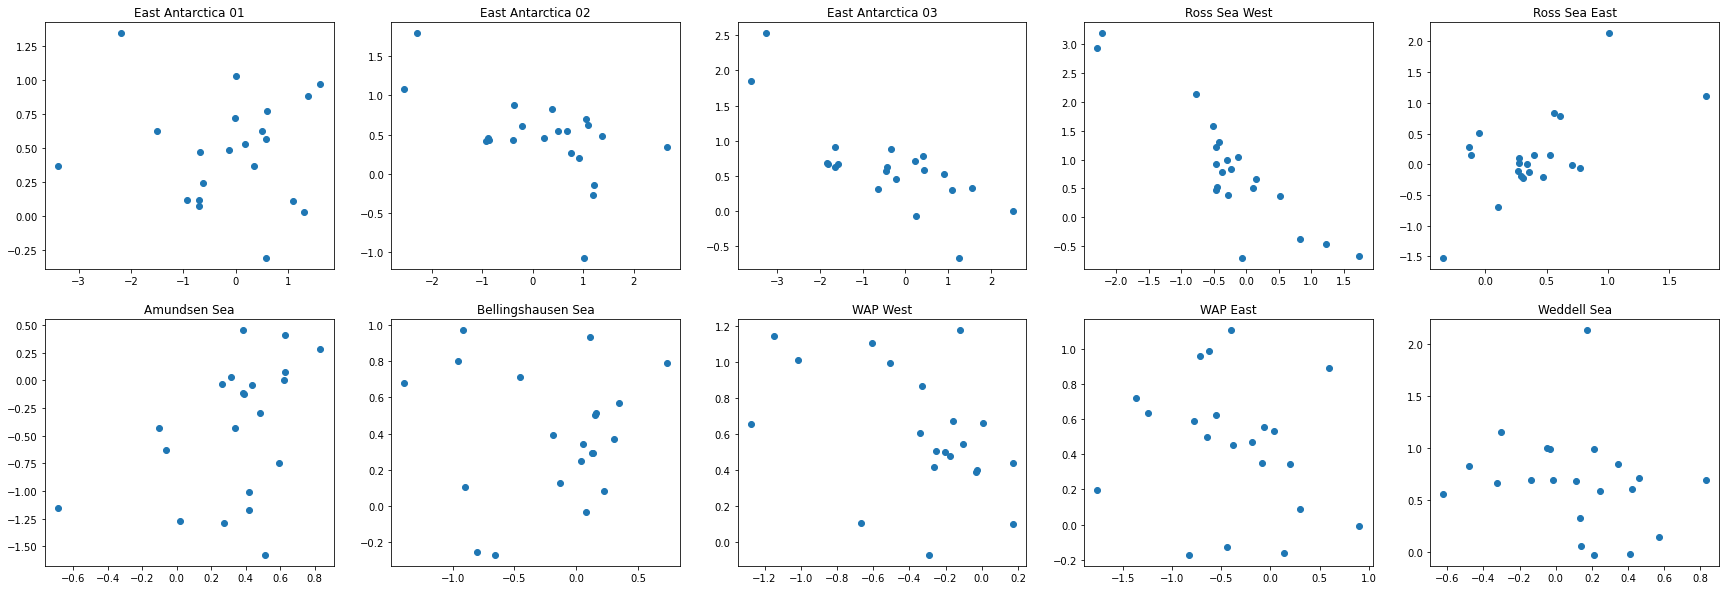

In [39]:
fig = plt.figure(figsize = (30, 10))
gr = gs.GridSpec(2, 5, figure = fig)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
       fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
       fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])]
for l in range(len(locs)):
    axs[l].set_title(locs[l])
    axs[l].scatter(uas_biases[:,l], vas_biases[:,l])

# Biases per season

In [5]:
uas_finer_clim = {}
vas_finer_clim = {}
for n in model_names:
    uas_finer_clim[n] = uas[n]['uas'].groupby('time.season').mean('time').interp(lon = basins['lon'], lat = basins['lat'])
    vas_finer_clim[n] = vas[n]['vas'].groupby('time.season').mean('time').interp(lon = basins['lon'], lat = basins['lat'])

In [22]:
uas_clim_anom = {}
vas_clim_anom = {}
for n in model_names[1:]:
    uas_clim_anom[n] = uas_finer_clim[n] - uas_finer_clim['ERAI']
    vas_clim_anom[n] = vas_finer_clim[n] - vas_finer_clim['ERAI']

In [24]:
uas_biases_seasonal = np.empty([4, len(model_names)-1, len(locs)])
vas_biases_seasonal = np.empty([4, len(model_names)-1, len(locs)])
for s in range(4):
    for n in range(len(model_names[1:])):
        for l in range(len(locs)):
            uas_biases_seasonal[s, n, l] = uas_clim_anom[model_names[n+1]].isel(season = s).where(basins == l+2, np.nan).mean(['lon', 'lat'])
            vas_biases_seasonal[s, n, l] = vas_clim_anom[model_names[n+1]].isel(season = s).where(basins == l+2, np.nan).mean(['lon', 'lat'])

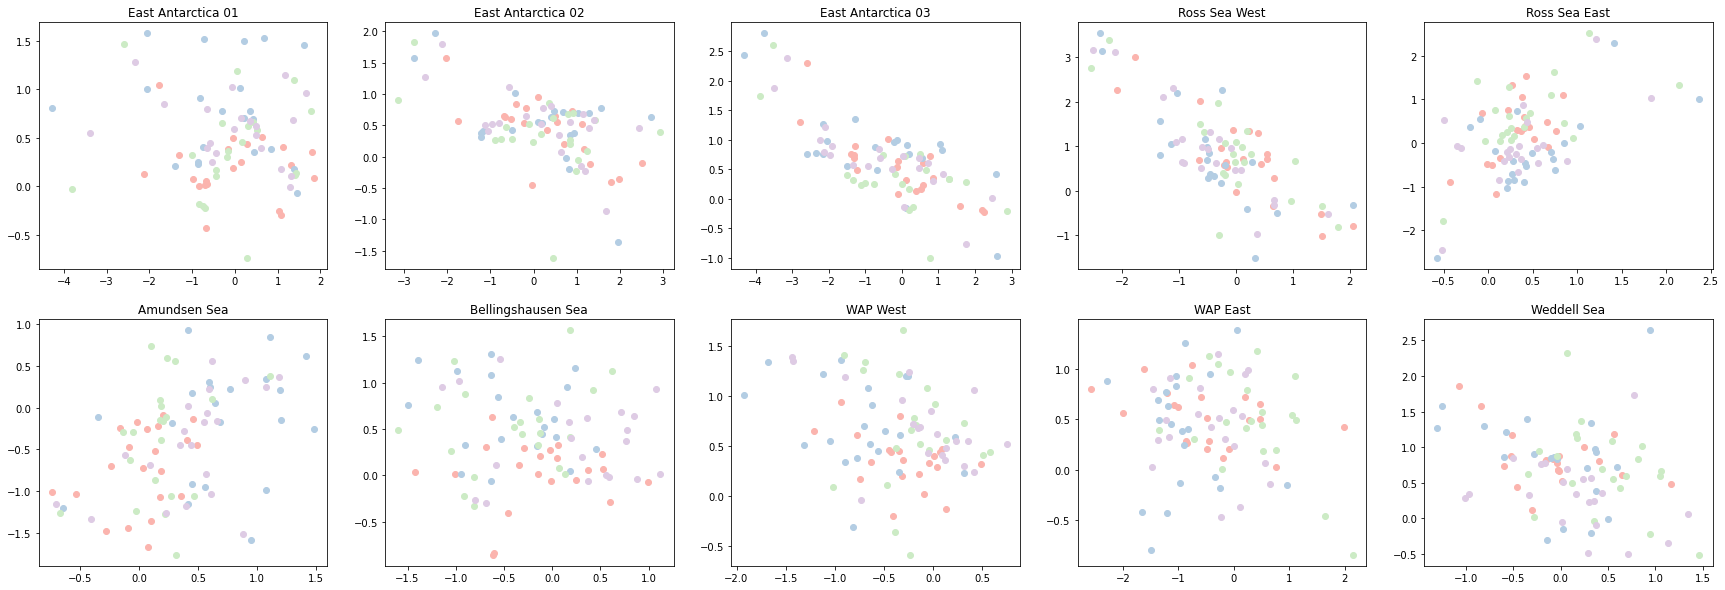

In [28]:
fig = plt.figure(figsize = (30, 10))
gr = gs.GridSpec(2, 5, figure = fig)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
       fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
       fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])]
for n in range(len(locs)):
    for s in range(4):
        axs[n].set_title(locs[n])
        axs[n].scatter(uas_biases_seasonal[s,:,n], vas_biases_seasonal[s,:,n], color = Pastel1_4.mpl_colors[s])